In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA
register_matplotlib_converters()
from datetime import datetime


# ICE CREAM PRODUCTION DATA 

In [10]:
# parser function to convert the dates within the data into datetime 
def parser(s):
  return datetime.strptime(s, '%Y-%m-%d')

In [12]:
#read data
# We do the the datetime parsing in the beginning itself so that we can avoid any processing later 
production_ice_cream = pd.read_csv('https://raw.githubusercontent.com/ritvikmath/Time-Series-Analysis/master/ice_cream.csv', parse_dates = [0], index_col = 0, squeeze=True, date_parser = parser)

In [20]:
production_ice_cream.rename('production', inplace = True)

DATE
2010-01-01     91.2895
2010-02-01    110.4994
2010-03-01    127.0971
2010-04-01    132.6468
2010-05-01    134.5576
                ...   
2019-09-01    100.1741
2019-10-01     90.1684
2019-11-01     79.7223
2019-12-01     75.7094
2020-01-01     83.6290
Freq: MS, Name: production, Length: 121, dtype: float64

In [14]:
# infering the frequency of Data 
production_ice_cream = production_ice_cream.asfreq(pd.infer_freq(production_ice_cream.index))

In [15]:
production_ice_cream

DATE
1972-01-01     59.9622
1972-02-01     67.0605
1972-03-01     74.2350
1972-04-01     78.1120
1972-05-01     84.7636
                ...   
2019-09-01    100.1741
2019-10-01     90.1684
2019-11-01     79.7223
2019-12-01     75.7094
2020-01-01     83.6290
Freq: MS, Name: production, Length: 577, dtype: float64

In [16]:
# Lets get the data from 2010 onwards 
start_date = pd.to_datetime('2010-01-01')
production_ice_cream = production_ice_cream[start_date:]

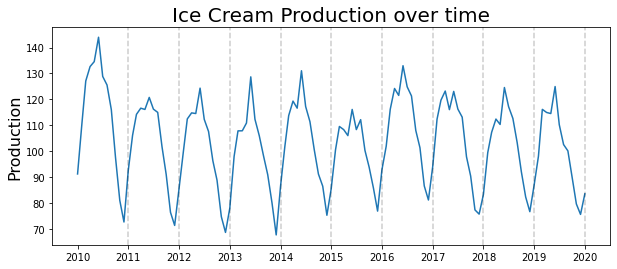

In [17]:
plt.figure(figsize=(10,4))
plt.plot(production_ice_cream)
plt.title('Ice Cream Production over time', fontsize = 20)
plt.ylabel('Production', fontsize = 16)
for year in range(2011,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2) 

ACF and PACF plots 

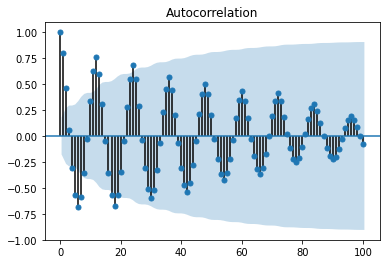

In [23]:
acf_plot = plot_acf(production_ice_cream, lags=100)

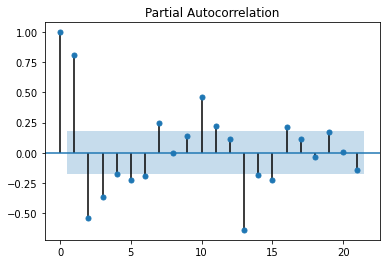

In [24]:
pacf_plot = plot_pacf(production_ice_cream)

# AR MODELS 
From our PACF plot we can understand that we have correlation at 1,2,3,10,13. We can start with a AR-3 model and then try various other models in order to understand the performance. 

In [26]:
# getting the training and test datasets
from datetime import timedelta
train_end = datetime(2018,12,1)
test_end = datetime(2019,12,1)

train_data = production_ice_cream[:train_end]
test_data = production_ice_cream[train_end + timedelta(days=1):test_end]

In [27]:
# create the model 
# (3,0) : AR = 3 , MA = 0
from time import time
model = ARMA(train_data, order=(3,0))
start = time()
model_fit = model.fit()
end = time()
print("Model fitting time : {}".format(end-start))

Model fitting time : 0.14342975616455078


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [28]:
# Have a look at p values as p values will tell us whether our lags correlate strongly to our predictions or not 
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:             production   No. Observations:                  108
Model:                     ARMA(3, 0)   Log Likelihood                -374.085
Method:                       css-mle   S.D. of innovations              7.642
Date:                Fri, 16 Sep 2022   AIC                            758.170
Time:                        02:38:46   BIC                            771.580
Sample:                    01-01-2010   HQIC                           763.607
                         - 12-01-2018                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              103.5742      1.809     57.265      0.000     100.029     107.119
ar.L1.production     1.0469      0.088     11.960      0.000       0.875       1.218
ar.L2.production    -0.0523 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


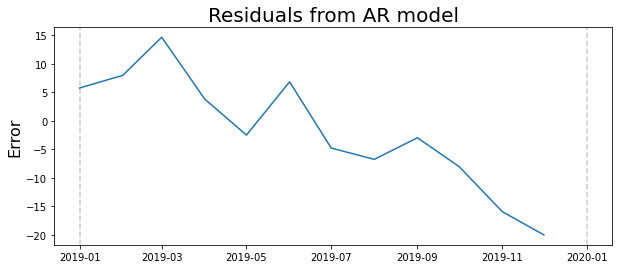

In [29]:
# get predictions from the model 
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

predictions = model_fit.predict(start = pred_start_date, end = pred_end_date)
residuals = test_data-predictions 

# Plotting the residuals 
# If there is a pattern within the residuals then there is  aproblem with our model selection. For e.g if residuals are dropping then our model will be 
# problematic 

plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Residuals from AR model', fontsize = 20)
plt.ylabel('Error', fontsize = 16)
for year in range(2019,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

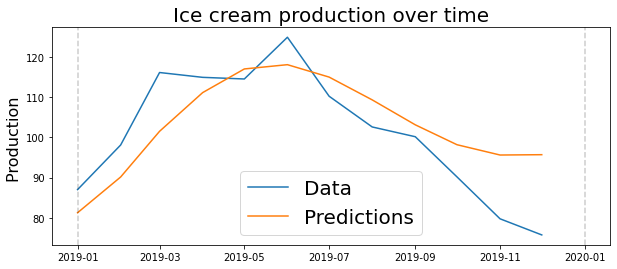

In [30]:
# Plotting predictions over the real data 
plt.figure(figsize=(10,4))

plt.plot(test_data)
plt.plot(predictions)


plt.legend(('Data','Predictions'), fontsize = 20)
plt.title('Ice cream production over time', fontsize = 20)

plt.ylabel('Production ', fontsize = 16)
for year in range(2019,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [31]:
print('Mean absolute percentage error:', round(np.mean(abs(residuals/test_data)),4))

Mean absolute percentage error: 0.0895


In [32]:
print("Root Mean Squared Error : ", np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error :  9.884058134957062


# AR 7 Model 

In [33]:
# create the model 
# (3,0) : AR = 3 , MA = 0
from time import time
model = ARMA(train_data, order=(7,0))
start = time()
model_fit = model.fit()
end = time()
print("Model fitting time : {}".format(end-start))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


Model fitting time : 1.930117130279541


In [34]:
# Have a look at p values as p values will tell us whether our lags correlate strongly to our predictions or not 
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:             production   No. Observations:                  108
Model:                     ARMA(7, 0)   Log Likelihood                -361.526
Method:                       css-mle   S.D. of innovations              6.754
Date:                Fri, 16 Sep 2022   AIC                            741.051
Time:                        02:48:47   BIC                            765.191
Sample:                    01-01-2010   HQIC                           750.839
                         - 12-01-2018                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              103.6216      1.159     89.389      0.000     101.350     105.894
ar.L1.production     0.9497      0.092     10.267      0.000       0.768       1.131
ar.L2.production    -0.0964 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


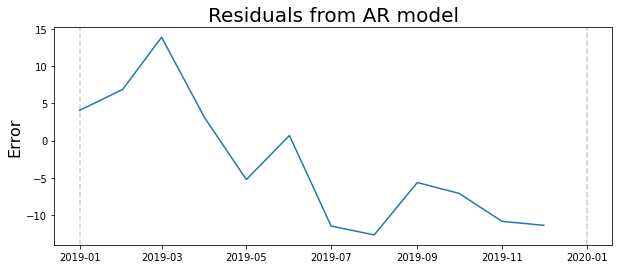

In [35]:
# get predictions from the model 
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

predictions = model_fit.predict(start = pred_start_date, end = pred_end_date)
residuals = test_data-predictions 

# Plotting the residuals 
# If there is a pattern within the residuals then there is  aproblem with our model selection. For e.g if residuals are dropping then our model will be 
# problematic 

plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Residuals from AR model', fontsize = 20)
plt.ylabel('Error', fontsize = 16)
for year in range(2019,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

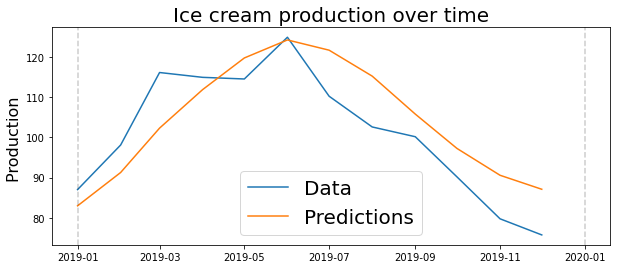

In [36]:
# Plotting predictions over the real data 
plt.figure(figsize=(10,4))

plt.plot(test_data)
plt.plot(predictions)


plt.legend(('Data','Predictions'), fontsize = 20)
plt.title('Ice cream production over time', fontsize = 20)

plt.ylabel('Production ', fontsize = 16)
for year in range(2019,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [37]:
print('Mean absolute percentage error:', round(np.mean(abs(residuals/test_data)),4))

Mean absolute percentage error: 0.0802


In [38]:
print("Root Mean Squared Error : ", np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error :  8.725150914894572


# AR 11 Model 

In [39]:
# create the model 
# (3,0) : AR = 3 , MA = 0
from time import time
model = ARMA(train_data, order=(11,0))
start = time()
model_fit = model.fit()
end = time()
print("Model fitting time : {}".format(end-start))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


Model fitting time : 16.629321813583374


In [40]:
# Have a look at p values as p values will tell us whether our lags correlate strongly to our predictions or not 
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:             production   No. Observations:                  108
Model:                    ARMA(11, 0)   Log Likelihood                -334.544
Method:                       css-mle   S.D. of innovations              5.112
Date:                Fri, 16 Sep 2022   AIC                            695.087
Time:                        02:50:37   BIC                            729.955
Sample:                    01-01-2010   HQIC                           709.225
                         - 12-01-2018                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               104.9739      3.081     34.073      0.000      98.935     111.012
ar.L1.production      0.8297      0.095      8.721      0.000       0.643       1.016
ar.L2.production      0.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


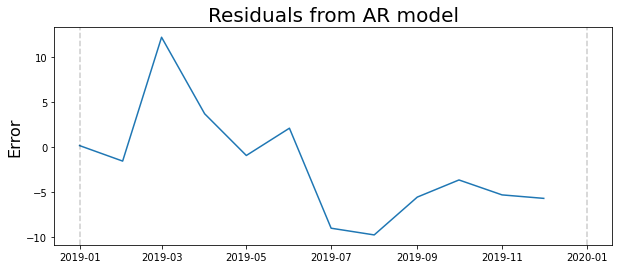

In [41]:
# get predictions from the model 
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

predictions = model_fit.predict(start = pred_start_date, end = pred_end_date)
residuals = test_data-predictions 

# Plotting the residuals 
# If there is a pattern within the residuals then there is  aproblem with our model selection. For e.g if residuals are dropping then our model will be 
# problematic 

plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Residuals from AR model', fontsize = 20)
plt.ylabel('Error', fontsize = 16)
for year in range(2019,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

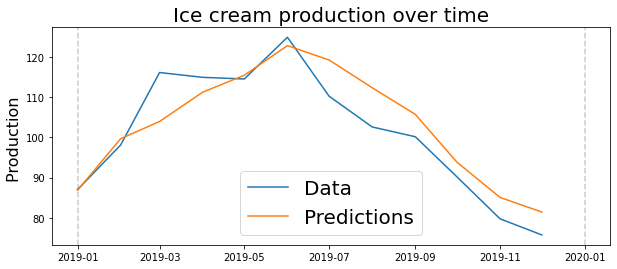

In [42]:
# Plotting predictions over the real data 
plt.figure(figsize=(10,4))

plt.plot(test_data)
plt.plot(predictions)


plt.legend(('Data','Predictions'), fontsize = 20)
plt.title('Ice cream production over time', fontsize = 20)

plt.ylabel('Production ', fontsize = 16)
for year in range(2019,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [43]:
print('Mean absolute percentage error:', round(np.mean(abs(residuals/test_data)),4))

Mean absolute percentage error: 0.0496


In [44]:
print("Root Mean Squared Error : ", np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error :  6.141862008288208


# Rolling Forecast Origin 

Train on months 1,2,3,...., k-3 and predict k-2
Train 1,2,3.........., k-2 predict k-1
Train 1,2,3,.........., k-1 predict k 
....
...

Take average of all predictions 

In [45]:
# getting the training and test datasets
from datetime import timedelta
train_end = datetime(2016,12,1)
test_end = datetime(2019,12,1)

train_data = production_ice_cream[:train_end]
test_data = production_ice_cream[train_end + timedelta(days=1):test_end]

In [46]:
predictions_rolling = pd.Series()
for end_date in test_data.index:
  train_data = production_ice_cream[:end_date-timedelta(days=1)]
  model = ARMA(train_data, order = (3,0))
  model_fit = model.fit()
  pred = model_fit.predict(end_date)
  predictions_rolling.loc[end_date] = pred.loc[end_date]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


In [47]:
residuls = test_data-predictions_rolling

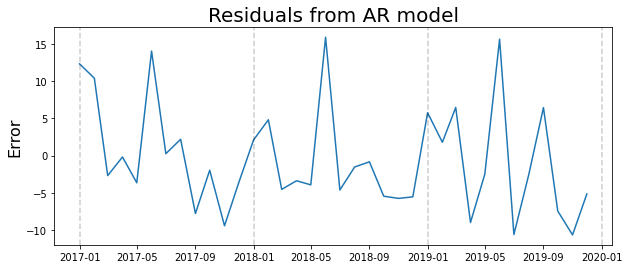

In [51]:
plt.figure(figsize=(10,4))
plt.plot(residuls)
plt.title('Residuals from AR model', fontsize = 20)
plt.ylabel('Error', fontsize = 16)
for year in range(2017,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

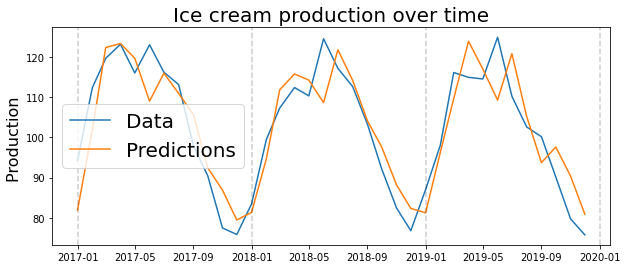

In [52]:
plt.figure(figsize=(10,4))

plt.plot(test_data)
plt.plot(predictions_rolling)


plt.legend(('Data','Predictions'), fontsize = 20)
plt.title('Ice cream production over time', fontsize = 20)

plt.ylabel('Production ', fontsize = 16)
for year in range(2017,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)